In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from keras.callbacks import EarlyStopping
import pandas_ta as ta

In [63]:
spy_data = pd.read_csv('spy.csv')
vix_data = pd.read_csv('vix.csv')

# Merge SPY and VIX data on 'Date'
data = pd.merge(spy_data, vix_data, on='Date', suffixes=('_SPY', '_VIX'))

# Ensure Date is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)


In [64]:
data.head()

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Adj Close_SPY,Volume_SPY,Open_VIX,High_VIX,Low_VIX,Close_VIX,Adj Close_VIX,Volume_VIX
Date,,,,,,,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,24.684107,1003200,12.49,13.16,12.42,12.42,12.42,0.0
1993-02-01,43.96875,44.25000,43.96875,44.25000,24.859661,480500,12.51,12.92,12.18,12.33,12.33,0.0
1993-02-02,44.21875,44.37500,44.12500,44.34375,24.912336,201300,12.47,12.89,12.22,12.25,12.25,0.0
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.175682,529400,11.98,12.34,11.79,12.12,12.12,0.0
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.281008,531500,11.86,12.84,11.69,12.29,12.29,0.0


In [65]:
data.shape

(7963, 12)

In [66]:
data.columns

Index(['Open_SPY', 'High_SPY', 'Low_SPY', 'Close_SPY', 'Adj Close_SPY',
       'Volume_SPY', 'Open_VIX', 'High_VIX', 'Low_VIX', 'Close_VIX',
       'Adj Close_VIX', 'Volume_VIX'],
      dtype='object')

In [67]:
# Add Indicators
# Add Moving Averages
for ma_window in [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233]:
    data[f'MA_{ma_window}'] = ta.sma(data['Close_SPY'], length=ma_window)

# Add Exponential Moving Averages
for ema_window in [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233]:
    data[f'EMA_{ema_window}'] = ta.ema(data['Close_SPY'], length=ema_window)

# Add RSI
for rsi_window in [14, 21]:  # You can add more intervals if needed
    data[f'RSI_{rsi_window}'] = ta.rsi(data['Close_SPY'], length=rsi_window)
    

In [68]:
data.shape

(7963, 36)

In [69]:
data.columns

Index(['Open_SPY', 'High_SPY', 'Low_SPY', 'Close_SPY', 'Adj Close_SPY',
       'Volume_SPY', 'Open_VIX', 'High_VIX', 'Low_VIX', 'Close_VIX',
       'Adj Close_VIX', 'Volume_VIX', 'MA_2', 'MA_3', 'MA_5', 'MA_8', 'MA_13',
       'MA_21', 'MA_34', 'MA_55', 'MA_89', 'MA_144', 'MA_233', 'EMA_2',
       'EMA_3', 'EMA_5', 'EMA_8', 'EMA_13', 'EMA_21', 'EMA_34', 'EMA_55',
       'EMA_89', 'EMA_144', 'EMA_233', 'RSI_14', 'RSI_21'],
      dtype='object')

In [70]:
data.head()

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Adj Close_SPY,Volume_SPY,Open_VIX,High_VIX,Low_VIX,Close_VIX,...,EMA_8,EMA_13,EMA_21,EMA_34,EMA_55,EMA_89,EMA_144,EMA_233,RSI_14,RSI_21
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,24.684107,1003200,12.49,13.16,12.42,12.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,43.96875,44.25000,43.96875,44.25000,24.859661,480500,12.51,12.92,12.18,12.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,44.21875,44.37500,44.12500,44.34375,24.912336,201300,12.47,12.89,12.22,12.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.175682,529400,11.98,12.34,11.79,12.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.281008,531500,11.86,12.84,11.69,12.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
df = data[['Open_SPY', 'High_SPY', 'Low_SPY', 'Close_SPY', 'Adj Close_SPY',
       'Volume_SPY', 'Open_VIX', 'High_VIX', 'Low_VIX', 'Close_VIX',
       'Adj Close_VIX', 'Volume_VIX', 'MA_2', 'MA_3', 'MA_5', 'MA_8', 'MA_13',
       'MA_21', 'MA_34', 'MA_55', 'MA_89', 'MA_144', 'MA_233', 'EMA_2',
       'EMA_3', 'EMA_5', 'EMA_8', 'EMA_13', 'EMA_21', 'EMA_34', 'EMA_55',
       'EMA_89', 'EMA_144', 'EMA_233', 'RSI_14', 'RSI_21']].copy(deep=True)
features_df = df.fillna(0.0)
shape_y=features_df.shape[1]-1
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features_df)

# Define function to create dataset with lookback
def create_dataset(data, lookback=1):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), :])
        y.append(data[i + lookback, 3])  
    return np.array(X), np.array(y)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

lookback = 3  
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

# Reshape 3D input 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))



In [136]:
# Build LSTM Network
model = Sequential()

# Input layer
model.add(Input(shape=(lookback, X_train.shape[2])))

# Add LSTM layers
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(units=512)))
model.add(Dense(1))
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), 
                    verbose=1, shuffle=True)


Epoch 1/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 172ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - loss: 6.5243e-05 - val_loss: 3.5715e-04
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - loss: 4.8906e-05 - val_loss: 5.9075e-04
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 6.5289e-05 - val_loss: 2.3157e-04
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 163ms/step - loss: 7.9850e-05 - val_loss: 0.0012
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - loss: 1.8260e-04 - val_loss: 0.0015
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - loss: 6.7097e-05 - val_loss: 5.1991e-04
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step - loss: 3.4871e-05 - val_loss: 0.0019
Epoch 9/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 4.0000e-05 - val_loss: 9.3056e-04
Epoch 10/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 4.2256e-05 - val_loss: 7.0701e-04


In [137]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], shape_y))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], shape_y))), axis=1))[:, 0]

# Inverse transform actual values
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], shape_y))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], shape_y))), axis=1))[:, 0]


199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


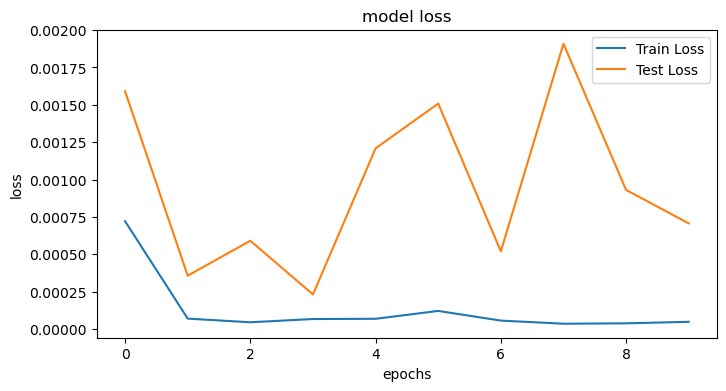

In [139]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

Train RMSE: 3.497248359042244
Test RMSE: 13.822305573634354


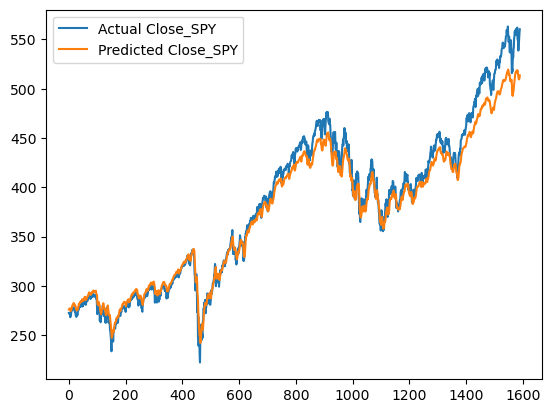

In [140]:
# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plot predictions
plt.plot(y_test_actual, label="Actual Close_SPY")
plt.plot(test_predict, label="Predicted Close_SPY")
plt.legend()
plt.show()